Name of current CUDA device: NVIDIA GeForce RTX 3050 Laptop GPU
Количество примеров в обучающем наборе для каждого класса:
type
0    9920
1    2744
Name: count, dtype: int64
10002
tensor([0.2167, 0.7833], device='cuda:0')
Epoch 1/35 - Train Loss: 0.6931, Train Accuracy: 0.4349, Test Loss: 0.6932, Test Accuracy: 0.3006, Learning Rate: 0.000100
Epoch 2/35 - Train Loss: 0.6927, Train Accuracy: 0.4399, Test Loss: 0.6928, Test Accuracy: 0.2826, Learning Rate: 0.000595
Epoch 3/35 - Train Loss: 0.6894, Train Accuracy: 0.5143, Test Loss: 0.6697, Test Accuracy: 0.5336, Learning Rate: 0.001090
Epoch 4/35 - Train Loss: 0.6410, Train Accuracy: 0.6159, Test Loss: 0.5777, Test Accuracy: 0.7708, Learning Rate: 0.001585
Epoch 5/35 - Train Loss: 0.5055, Train Accuracy: 0.7877, Test Loss: 0.5000, Test Accuracy: 0.7373, Learning Rate: 0.002080
Epoch 6/35 - Train Loss: 0.4316, Train Accuracy: 0.8718, Test Loss: 0.4863, Test Accuracy: 0.7556, Learning Rate: 0.002575
Epoch 7/35 - Train Loss: 0.3964, Train A

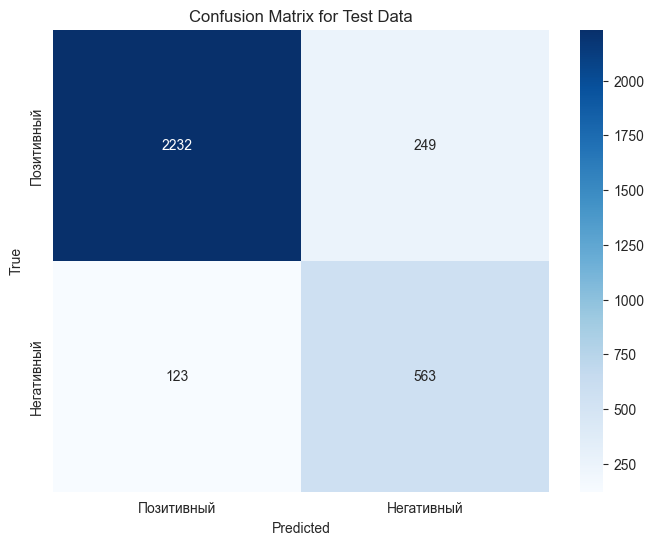

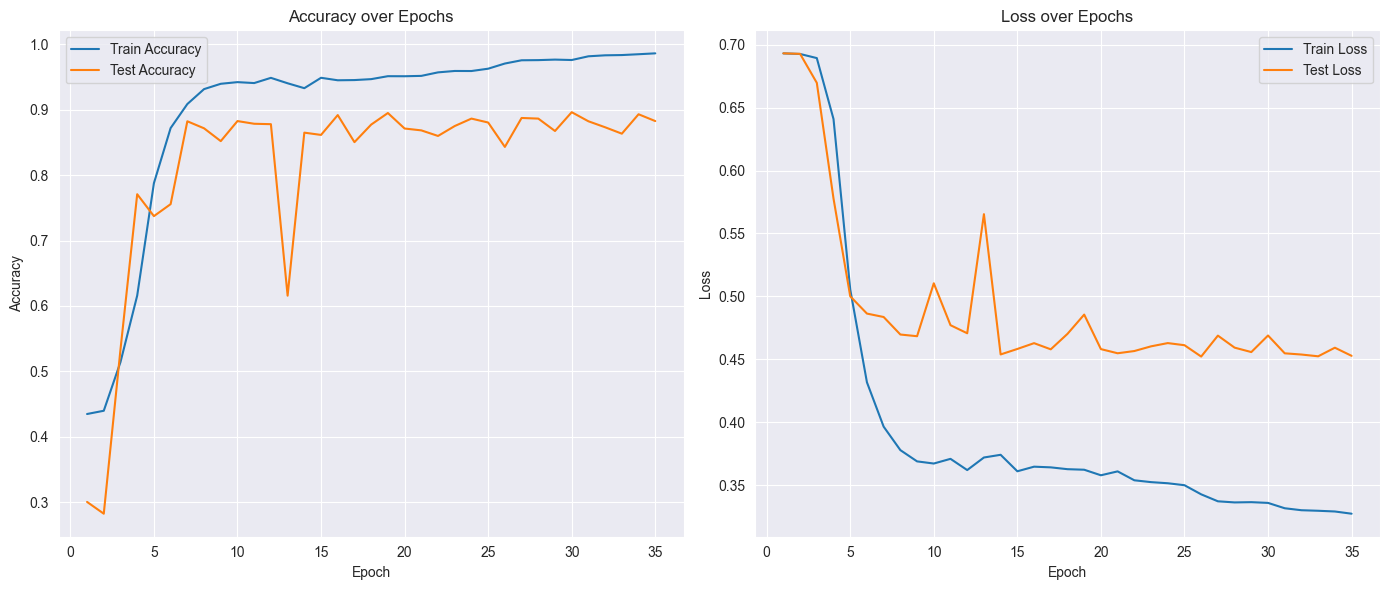

In [41]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cuda_id = torch.cuda.current_device()
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

data = pd.read_csv('cleaned_reviews.csv')

data = data[data['type'] != "Нейтральный"]

def word_count(text):
    return len(text.split())

data['word_count'] = data['review'].apply(word_count)
data = data[(data['word_count'] >= 50) & (data['word_count'] <= 500)]

stop_words = set(stopwords.words('russian'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    return ' '.join(lemmatized_words)

data['review'] = data['review'].apply(preprocess_text)

X = data['review']
y = data['type'].map({"Позитивный": 0, "Негативный": 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

class_counts = y_train.value_counts()
print("Количество примеров в обучающем наборе для каждого класса:")
print(class_counts)

all_words = ' '.join(data['review']).split()
word_counts = Counter(all_words)
max_vocab_size = 10000

vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_counts.most_common(max_vocab_size))}
vocab['<unk>'] = 0
vocab['<pad>'] = 1
print(len(vocab))

def text_pipeline(text):
    return [vocab.get(word, vocab['<unk>']) for word in word_tokenize(text) if word.isalpha()]

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return text_pipeline(self.texts.iloc[idx]), self.labels.iloc[idx]

train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

batch_size = 128

def collate_batch(batch):
    texts, labels = zip(*batch)
    texts = nn.utils.rnn.pad_sequence([torch.tensor(t, dtype=torch.int64) for t in texts], batch_first=True, padding_value=vocab['<pad>'])
    labels = torch.tensor(labels, dtype=torch.int64)
    return texts.to(device), labels.to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_output):
        attn_weights = torch.softmax(self.attn(lstm_output), dim=1)
        attn_output = torch.sum(attn_weights * lstm_output, dim=1)
        return attn_output

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = Attention(2 * hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_dim, 64),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_output, _ = self.lstm(embedded)
        attn_output = self.attn(lstm_output)
        output = self.fc(attn_output)
        return self.softmax(output)

embedding_dim = 100
hidden_dim = 64
output_dim = 2

model = LSTMClassifier(len(vocab), embedding_dim, hidden_dim, output_dim).to(device)

class_counts_balanced = y_train.value_counts()
class_weights_balanced = 1. / class_counts_balanced
class_weights_balanced = class_weights_balanced / class_weights_balanced.sum()

weights_balanced = torch.tensor(class_weights_balanced.values, dtype=torch.float).to(device)
print(weights_balanced)

criterion = nn.CrossEntropyLoss(weight=weights_balanced)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=0.01, step_size_up=20, mode='triangular2')

epochs = 35
train_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for texts, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    model.eval()
    total_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for texts, labels in test_loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = correct_test / total_test
    test_losses.append(total_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}, "
          f"Learning Rate: {lr:.6f}")

    scheduler.step()

print("Final Classification Report (Train Data):")
train_preds, train_labels = [], []
for texts, labels in train_loader:
    texts = texts.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(texts)
        _, predicted = torch.max(outputs, 1)
    train_preds.extend(predicted.cpu().numpy())
    train_labels.extend(labels.cpu().numpy())

print(classification_report(train_labels, train_preds, target_names=["Позитивный", "Негативный"]))

print("Final Classification Report (Test Data):")
test_preds, test_labels = [], []
for texts, labels in test_loader:
    texts = texts.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(texts)
        _, predicted = torch.max(outputs, 1)
    test_preds.extend(predicted.cpu().numpy())
    test_labels.extend(labels.cpu().numpy())

print(classification_report(test_labels, test_preds, target_names=["Позитивный", "Негативный"]))

conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Позитивный", "Негативный"],
            yticklabels=["Позитивный", "Негативный"])
plt.title('Confusion Matrix for Test Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
axes[0].plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
axes[0].set_title('Accuracy over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(range(1, epochs + 1), train_losses, label='Train Loss')
axes[1].plot(range(1, epochs + 1), test_losses, label='Test Loss')
axes[1].set_title('Loss over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()